### Logistic Regression Classifier - Malwai

In [1]:
%matplotlib inline

import os
import sys
import json
import keras

from pathlib import Path
from pathlib import PureWindowsPath

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights)

# Constants for Functions
ALGORITHM_NAME = 'lr'
COUNTRY = 'mwi'


Using TensorFlow backend.


In [2]:
# Load the processed Mwai household:
mwi_hhold = pd.read_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_household.csv")

In [3]:
# Split Malawi data 
mwi_train, mwi_test = train_test_split(mwi_hhold, 
                                       test_size=0.25,
                                       random_state=1443,
                                       stratify=mwi_hhold.poor)

In [4]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(mwi_train)

In [5]:
# summarize Train loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*mwi_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*mwi_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
mwi_train.head()

Data has 9,183 rows and 488 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,hid,wta_hh,wta_pop,der_hhsize,poor,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
7927,304044580160,170.1948,850.9740,5,True,3,0.0,1.0,3,1,...,0,0,0,0,0,0,0,0,0,0
4210,205205820123,188.8692,566.6076,3,False,2,1.0,3.0,1,1,...,1,0,0,0,0,0,0,0,0,0
457,102016880095,143.9194,863.5164,6,True,5,0.0,2.0,3,1,...,0,0,0,0,0,0,0,0,0,0
11951,315356330210,234.7279,704.1837,3,False,3,3.0,3.0,1,1,...,1,1,0,0,0,0,0,0,1,1
11428,313061660067,78.5482,157.0964,2,False,1,0.0,2.0,0,1,...,1,0,0,1,0,0,0,0,0,0


In [6]:
# Select a few columns for this example
selected_columns = [
    'der_hhsize', 
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

print("X shape with selected columns:", mwi_train[selected_columns].shape)

X shape with selected columns: (9183, 10)


## Checking for Multicollinearity:
### Calcualting the variance inflation factor (VIF) of each feature.

In [7]:
def get_vif(X, intercept_col='intercept'):
    if intercept_col is not None and intercept_col in X.columns:
        X = X.copy().drop(intercept_col, axis=1)
    
    vi_factors = [variance_inflation_factor(X.values, i)
                             for i in range(X.shape[1])]
    
    return pd.Series(vi_factors,
                     index=X.columns,
                     name='variance_inflaction_factor')

In [8]:
get_vif(mwi_train[selected_columns])

der_hhsize               1142.050480
der_nchild10under         206.466307
der_nmalesover10          138.021692
der_nfemalesover10        141.867242
der_nliterate               5.616642
der_nemployedpastyear       1.533041
hld_electricity__Yes        1.471163
hld_toilet__None            1.091630
cons_0504__Yes              1.344652
cons_0508__Yes              1.341629
Name: variance_inflaction_factor, dtype: float64

### Standardization 

In [9]:
# Standardize features
def standardize(df, numeric_only=True):
    if numeric_only is True:
    # find non-boolean columns
        cols = df.loc[:, df.dtypes != 'uint8'].columns
    else:
        cols = df.columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

In [10]:
standardize(mwi_train)

,hid,wta_hh,wta_pop,der_hhsize,poor,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
7927,0.898019,-0.463091,-0.289299,0.183527,1.102410,0.326073,-0.597364,-1.131563,0.977090,-0.398378,...,-1.700716,-0.593458,-0.321636,-0.198159,-0.096077,-0.150344,-0.545987,-0.150344,-0.592787,-0.258440
4210,-0.375839,-0.356672,-0.560014,-0.721591,-0.907005,-0.512205,0.398207,1.089716,-0.483297,-0.398378,...,0.587923,-0.593458,-0.321636,-0.198159,-0.096077,-0.150344,-0.545987,-0.150344,-0.592787,-0.258440
457,-1.705763,-0.612824,-0.277359,0.636087,1.102410,2.002628,-0.597364,-0.020924,0.977090,-0.398378,...,-1.700716,-0.593458,-0.321636,-0.198159,-0.096077,-0.150344,-0.545987,-0.150344,-0.592787,-0.258440
11951,1.043807,-0.095341,-0.429043,-0.721591,-0.907005,0.326073,2.389348,1.089716,-0.483297,-0.398378,...,0.587923,1.684855,-0.321636,-0.198159,-0.096077,-0.150344,-0.545987,-0.150344,1.686762,3.868954
11428,1.014233,-0.985350,-0.949866,-1.174151,-0.907005,-1.350483,-0.597364,-0.020924,-1.213490,-0.398378,...,0.587923,-0.593458,-0.321636,5.045910,-0.096077,-0.150344,-0.545987,-0.150344,-0.592787,-0.258440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430,-0.339037,1.670244,2.011053,0.636087,1.102410,-0.512205,-0.597364,-1.131563,-0.483297,0.572252,...,0.587923,1.684855,-0.321636,-0.198159,-0.096077,-0.150344,-0.545987,-0.150344,1.686762,-0.258440
11107,1.013599,-0.966039,-0.709404,0.183527,-0.907005,-0.512205,-0.597364,1.089716,0.246897,-0.398378,...,0.587923,-0.593458,-0.321636,-0.198159,-0.096077,-0.150344,-0.545987,-0.150344,-0.592787,-0.258440
769,-1.692960,-0.698943,-0.976797,-1.626710,-0.907005,-1.350483,-0.597364,-0.020924,-1.213490,-0.398378,...,0.587923,-0.593458,-0.321636,-0.198159,-0.096077,6.650687,-0.545987,-0.150344,-0.592787,-0.258440
8471,0.923374,-0.730534,-0.747383,-0.721591,-0.907005,-1.350483,-0.597364,-0.020924,-0.483297,-0.398378,...,0.587923,-0.593458,-0.321636,-0.198159,-0.096077,-0.150344,-0.545987,6.650687,-0.592787,-0.258440


In [11]:
mwi_train[selected_columns]

,der_hhsize,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_electricity__Yes,hld_toilet__None,cons_0504__Yes,cons_0508__Yes
7927,0.183527,0.977090,-0.398378,-0.549568,-0.083075,-0.503193,-0.307632,-0.316665,-0.361605,-0.513617
4210,-0.721591,-0.483297,-0.398378,-0.549568,-0.083075,1.318897,-0.307632,-0.316665,-0.361605,-0.513617
457,0.636087,0.977090,-0.398378,0.535040,-0.083075,-0.503193,-0.307632,-0.316665,-0.361605,-0.513617
11951,-0.721591,-0.483297,-0.398378,-0.549568,0.492247,1.318897,3.250283,-0.316665,2.765151,1.946763
11428,-1.174151,-1.213490,-0.398378,-0.549568,-0.083075,-0.503193,-0.307632,-0.316665,-0.361605,-0.513617
...,...,...,...,...,...,...,...,...,...,...
5430,0.636087,-0.483297,0.572252,1.619648,-0.658397,-0.503193,-0.307632,-0.316665,-0.361605,-0.513617
11107,0.183527,0.246897,-0.398378,0.535040,-0.083075,-0.503193,-0.307632,-0.316665,-0.361605,-0.513617
769,-1.626710,-1.213490,-0.398378,-1.634176,-0.658397,-0.503193,-0.307632,3.157569,-0.361605,-0.513617
8471,-0.721591,-0.483297,-0.398378,-0.549568,-0.083075,-0.503193,-0.307632,-0.316665,-0.361605,-0.513617


In [12]:
get_vif(mwi_train[selected_columns])

der_hhsize               214.615373
der_nchild10under         83.536365
der_nmalesover10          48.129934
der_nfemalesover10        38.840336
der_nliterate              2.256896
der_nemployedpastyear      1.240740
hld_electricity__Yes       1.344728
hld_toilet__None           1.043755
cons_0504__Yes             1.194788
cons_0508__Yes             1.077015
Name: variance_inflaction_factor, dtype: float64

In [13]:
selected_columns.remove('der_hhsize')
print(selected_columns)

['der_nchild10under', 'der_nmalesover10', 'der_nfemalesover10', 'der_nliterate', 'der_nemployedpastyear', 'hld_electricity__Yes', 'hld_toilet__None', 'cons_0504__Yes', 'cons_0508__Yes']


In [14]:
get_vif(mwi_train[selected_columns])

der_nchild10under        1.054748
der_nmalesover10         1.511700
der_nfemalesover10       1.422928
der_nliterate            2.256803
der_nemployedpastyear    1.237311
hld_electricity__Yes     1.344378
hld_toilet__None         1.043731
cons_0504__Yes           1.194295
cons_0508__Yes           1.077012
Name: variance_inflaction_factor, dtype: float64

In [15]:
model = sm.Logit(y_train, X_train[selected_columns])
model = model.fit()

Optimization terminated successfully.
         Current function value: 0.517076
         Iterations 8


In [16]:
# The co-efficients 
def get_coefs_df(X, coefs, index=None, sort=True):
    coefs_df = pd.DataFrame(np.std(X, 0) * coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    if sort:
        coefs_df = coefs_df.sort_values('abs', ascending=False)
    return coefs_df

In [17]:
coefs = get_coefs_df(X_train[selected_columns], model.params)
coefs

,coef_std,coef,abs
hld_electricity__Yes,-0.803023,-2.857245,0.803023
cons_0508__Yes,-0.734580,-1.807445,0.734580
cons_0504__Yes,-0.633129,-1.979747,0.633129
der_nchild10under,0.597818,0.436547,0.597818
der_nliterate,-0.534401,-0.307470,0.534401
der_nemployedpastyear,-0.482136,-0.878544,0.482136
der_nmalesover10,0.275717,0.267634,0.275717
der_nfemalesover10,0.189929,0.206010,0.189929
hld_toilet__None,0.019980,0.069420,0.019980


In [18]:
# Run the model
y_prob = model.predict(X_train[selected_columns])
y_prob.head()

7927     0.762846
4210     0.358175
457      0.798083
11951    0.000534
11428    0.464735
dtype: float64

In [19]:
y_pred = (y_prob > 0.5)
y_pred.head()

7927      True
4210     False
457       True
11951    False
11428    False
dtype: bool

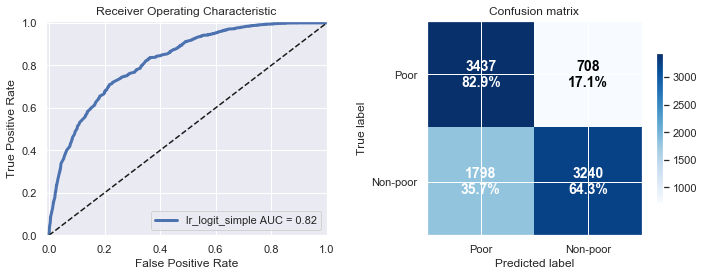

,lr_logit_simple
accuracy,0.727104
recall,0.829192
precision,0.656543
f1,0.732836
cross_entropy,0.517076
roc_auc,0.822459
cohen_kappa,0.461547


NameError: name 'pov_rate_actual' is not defined

In [20]:
# Evaluate performance
metrics = evaluation.evaluate_model(y_train, y_pred, y_prob, 
                                    store_model=True, 
                                    model_name='logit_simple', 
                                    prefix=ALGORITHM_NAME, 
                                    country=COUNTRY, 
                                    model=model, 
                                    features=coefs)

### Logit Model Evaluation

In [21]:
X_test, y_test, w_test = split_features_labels_weights(mwi_hhold)

In [22]:
standardize(X_test)

,hid,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
0,-1.718803,0.631464,-0.512009,-0.604215,-0.019798,1.707131,-0.405264,-0.546902,-0.086940,-0.511519,...,-1.719993,-0.597577,-0.321176,-0.198458,10.454539,-0.150441,-0.545238,-0.145542,-0.597577,-0.258143
1,-1.718803,-0.268926,0.326771,-0.604215,-1.126661,-0.478749,0.561432,-0.546902,-0.661407,-0.511519,...,-1.719993,-0.597577,-0.321176,-0.198458,10.454539,-0.150441,-0.545238,-0.145542,-0.597577,-0.258143
2,-1.718803,2.432243,2.843110,0.395516,-1.126661,1.707131,1.528128,1.619474,1.061995,1.312845,...,-1.719993,-0.597577,-0.321176,-0.198458,10.454539,-0.150441,-0.545238,-0.145542,-0.597577,-0.258143
3,-1.718803,1.982048,0.326771,-0.604215,-0.019798,1.707131,1.528128,0.536286,2.210930,-0.511519,...,-1.719993,-0.597577,-0.321176,-0.198458,10.454539,-0.150441,-0.545238,-0.145542,-0.597577,-0.258143
4,-1.718803,-1.619510,-0.512009,-0.604215,1.087066,-1.207376,-0.405264,-1.630090,-0.661407,-0.511519,...,-1.719993,-0.597577,-0.321176,-0.198458,10.454539,-0.150441,-0.545238,-0.145542,-0.597577,-0.258143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12239,1.041029,-0.719120,-0.512009,0.395516,-1.126661,-0.478749,-0.405264,-0.546902,-0.086940,1.312845,...,0.581350,-0.597577,-0.321176,-0.198458,-0.095644,-0.150441,1.833912,-0.145542,-0.597577,-0.258143
12240,1.041029,-1.169315,-1.350789,-0.604215,-0.019798,-1.207376,-0.405264,-0.546902,-0.661407,1.312845,...,0.581350,-0.597577,-0.321176,-0.198458,-0.095644,-0.150441,1.833912,-0.145542,-0.597577,-0.258143
12241,1.041029,-1.169315,-0.512009,0.395516,-0.019798,-1.207376,-0.405264,-0.546902,-0.086940,1.312845,...,0.581350,-0.597577,-0.321176,-0.198458,-0.095644,-0.150441,1.833912,-0.145542,-0.597577,-0.258143
12242,1.041029,0.181269,-0.512009,0.395516,-1.126661,0.249878,0.561432,-0.546902,-0.086940,3.137210,...,0.581350,-0.597577,-0.321176,-0.198458,-0.095644,-0.150441,1.833912,-0.145542,-0.597577,-0.258143


In [23]:
# Run the model
y_prob = model.predict(X_test[selected_columns])
y_prob.head()

0    0.970811
1    0.951913
2    0.124921
3    0.284905
4    0.898941
dtype: float64

In [24]:
y_pred = (y_prob > 0.5)
y_pred.head()

0     True
1     True
2    False
3    False
4     True
dtype: bool

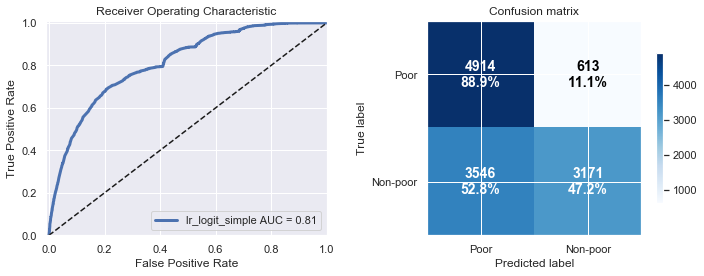

,lr_logit_simple
accuracy,0.660323
recall,0.889090
precision,0.580851
f1,0.702652
cross_entropy,0.881443
roc_auc,0.812102
cohen_kappa,0.344960


NameError: name 'pov_rate_actual' is not defined

In [25]:
# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    store_model=True, 
                                    model_name='logit_simple', 
                                    prefix=ALGORITHM_NAME, 
                                    country=COUNTRY, 
                                    model=model, 
                                    features=coefs)